# Event Segmentation Analysis

The following notebook contains the formal analysis procedure for the hidden markov modeling of continuous fMRI data.

# Formal model fitting procedure

As mentioned earlier, we are using `brainiak` to conduct our event segmentation analysis. This requires a separate `conda` environment

In [1]:
from sklearn.model_selection import LeaveOneOut, KFold
from brainiak.eventseg.event import EventSegment
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt 
import seaborn as sns

## Set up some variables

In [62]:
# n_subs = len(data) # total subjects
n_struct = len(roidata_masked["S"]) # subjects in the structured group
n_rand = len(roidata_masked["R"]) # subjects in the random group
n_splits_inner = 4
subj_id_struct = np.array([i for i in range(n_struct)])
subj_id_rand = np.array([i for i in range(n_rand)])

## Begin nested cross validation for **structured**.

In [35]:
def tuneK(train_data, test_data, k_vals:np.ndarray):
    """Tune K inside fold
    
    Parameters
    ----------
    train_data
        Training data, parsed by sklearn.model_selection.LeaveOneOut()
    test_data
        Test data, parsed by sklearn.model_selection.LeaveOneOut()    
        
    k_vals: np.ndarray
        Numpy array which contains all possible k values
    """

    log_likelihoods = np.zeros_like(k_vals)

    # test all the K values
    for i,K in enumerate(k_vals):

        # instantiate
        HMM = EventSegment(K)

            # fit and get log likely hoods
        HMM.fit(train_data)
        _, ll = HMM.find_events(test_data)
        log_likelihoods[i] = ll

    # find the best K value
    bestK = k_vals[np.argmax(log_likelihoods)]

    print('Tuned on k')

    return bestK, np.max(log_likelihoods)

In [36]:
def innerLoop(n_splits: int, idx: np.ndarray, outer_train_idx:np.ndarray, data:np.ndarray, k_vals:np.ndarray) -> int:

    # inner loop fold
    subj_id_all_inner = idx[outer_train_idx]
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(outer_train_idx)

    # track
    out = []
            
    # run loop
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):

        # format data
        train_data = np.mean(data[subj_id_train_inner, :, :],axis=0)
        test_data = np.mean(data[subj_id_test_inner, :, :], axis=0)

        # # run inner loop
        bestK, maxLL = tuneK(train_data=train_data, test_data=test_data, k_vals=k_vals)

        # append to tracker
        out.append((bestK, maxLL))

        print('Fold complete')

    # get best k
    k = [i[0] for i in out]
    ll = [i[1] for i in out]
    best = k[np.argmax(ll)]

    return int(best), out
    

In [37]:
def outerLoop(idx:np.ndarray, n_splits:int, data, k_vals:np.ndarray) -> pd.DataFrame:

    print('Beginning\n')
    print('----------\n')

    # initialize dataframe
    results = pd.DataFrame(columns=['subject', 'k', 'll'])

    # set up loo
    loo_outer = LeaveOneOut()
    subj_id_struct = idx
    loo_outer.get_n_splits(subj_id_struct)

    for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_struct):

        # run inner loop
        k2test, _ = innerLoop(n_splits=n_splits, outer_train_idx=subj_id_train_outer, data=data, k_vals=k_vals, idx=idx)

        # test on outer subject
        HMM = EventSegment(k2test)

        # outer_test
        outer_test_data = data[int(subj_id_test_outer[0]), :, :]

        # fit and get log likely hoods
        print(f'Fit to outer loop testing data\n')
        HMM.fit(outer_test_data)
        _, ll = HMM.find_events(outer_test_data)

        # aggregate values
        out2 = [str(subj_id_test_outer), k2test, ll]

        # append to dataframe
        results.loc[len(results)] = out2

    return results

# Running and fitting model on `structured`

In [2]:
idx = np.array([i for i in range(10)])
strucdat = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/struc_masked_conf_data.npy")
randat = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/rand_masked_conf_data.npy")
k_vals = np.arange(3, 15, 1)

In [39]:
ncv = outerLoop(idx=idx, n_splits=4, data=data, k_vals=k_vals)

Beginning

----------

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Tuned on k
Fold complete
Fit to outer loop testing data

Tuned on k
Fold complete
Tuned on k
Fold complete
Tun

In [98]:
ncv

,subject,k,ll
0,[0],2,-357.085501
1,[1],2,-350.694417
2,[2],2,-378.339772
3,[3],2,-340.179648
4,[4],2,-341.187614
5,[5],2,-383.707811
6,[6],2,-365.495508
7,[7],2,-382.404924
8,[8],2,-386.672820
9,[9],2,-374.179878


# Running and fitting model on `random`

In [24]:
idx2 = np.array([i for i in range(9)]) # change because uneven number of subjects
data2 = roidata_masked["R"]
k_vals = np.arange(2, 15, 1)

In [ ]:
ncv2 = outerLoop(idx=idx2, n_splits=4, data=data2, k_vals=k_vals)

In [104]:
ncv2

,subject,k,ll
0,[0],2,-358.338709
1,[1],2,-381.766007
2,[2],2,-255.749219
3,[3],2,-352.092198
4,[4],2,-374.786666
5,[5],2,-349.630398
6,[6],2,-374.620954
7,[7],2,-361.884130
8,[8],2,-366.958553


In [54]:
# n_subs = len(data) # total subjects
n_splits_inner = 4
nS = 10
subj_id_all = np.array([i for i in range(nS)])
loo_outer = LeaveOneOut()
subj_id_struct = idx
loo_outer.get_n_splits(subj_id_struct)

10

In [55]:
data.shape

(10, 240, 48)

In [56]:
ks = np.arange(3, 20, 1)
loglik=np.zeros((nS,nS,len(ks))) #preset a buncha variables
all_ll=np.zeros((n_splits_inner,len(ks)))
best_ll=np.zeros((nS,nS))
best_k_subj=np.zeros((nS))
lls_inner=np.zeros((nS))
lls_outer=np.zeros((nS))
events_subj=np.zeros((nS, 240))

for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)

    # set up inner loop loo structure
    subj_id_all_inner = subj_id_all[subj_id_train_outer]
    kf = KFold(n_splits=n_splits_inner)
    kf.get_n_splits(subj_id_train_outer)
    jj = 0

    print('Inner:')
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):

        # inplace update the ids w.r.t. to the inner training set
        subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
        subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]

        print("-Train:", subj_id_train_inner,"Validate:", subj_id_test_inner,
              ', now try different k...')
    
        D_train = data[subj_id_train_inner,:,:] #14 subjects to be trained
        D_val = data[subj_id_test_inner, :,:] #5 subjects for validation
        D_test = data[subj_id_test_outer,:,:] #held-out subject
        ks = np.arange(3, 15, 1)
        splitm = True

        for knum in range(len(ks)): #loop through all possible K values
            #ev = brainiak.eventseg.event.EventSegment(ks[knum]) #set up HMM

            if splitm: #if running split_merge
                ev = EventSegment(ks[knum],split_merge=True)
            else: #if no split_merge
                ev = EventSegment(ks[knum])

            ev.fit(D_train.mean(0)) #fit to average pattern of training set
            segments,ll=ev.find_events(D_val.mean(0))#grab segments + log lik on average of validation set
            #print('log likelihood for k=%s is %s' %(ks[knum],ll)) #uncomment to see ll values
            
            loglik[subj_id_test_outer,jj,knum] = ll #store loglik value for this K

        all_ll[jj,:]=loglik[subj_id_test_outer,jj,:]
        best_ll[subj_id_test_outer,jj] = np.max(loglik[subj_id_test_outer,jj,:]) #best loglik!
        jj=jj+1

    mean_all_ll=np.mean(all_ll,axis=0) #grab mean log lik
    fill3=mean_all_ll.argsort() #sort by log likelihood value
    fill3=fill3[len(ks)-1] #find best K

    print('Best K = %s' %fill3) #print best K
    best_k_subj[subj_id_test_outer]=ks[fill3] #store best k to assign for this sub

    if splitm: #if running split_merge
        ev = EventSegment(ks[fill3],split_merge=True) #re-train model w/ this best K
    else: #if no split_merge
        ev = EventSegment(ks[fill3]) #re-train model w/ this best K

    #ev.fit(D[:,:,np.arange(nS) != subj_id_test_outer].mean(2).T) #fit
    ev.fit(D_test.mean(0)) #fit
    segments,ll=ev.find_events(D_test.mean(0)) #apply model to find segments and log lik
    lls_outer[subj_id_test_outer]=np.max(ev.ll_) #store log lik
    events_subj[subj_id_test_outer,:]=np.argmax(ev.segments_[0], axis=1) #find event boundaries
    
print(lls_outer)
print(events_subj)

Outer:	Train: [1 2 3 4 5 6 7 8 9] Test: [0]
Inner:
-Train: [4 5 6 7 8 9] Validate: [1 2 3] , now try different k...
-Train: [1 2 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [1 2 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [1 2 3 4 5 6 7] Validate: [8 9] , now try different k...
Best K = 6
Outer:	Train: [0 2 3 4 5 6 7 8 9] Test: [1]
Inner:
-Train: [4 5 6 7 8 9] Validate: [0 2 3] , now try different k...
-Train: [0 2 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [0 2 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [0 2 3 4 5 6 7] Validate: [8 9] , now try different k...
Best K = 3
Outer:	Train: [0 1 3 4 5 6 7 8 9] Test: [2]
Inner:
-Train: [4 5 6 7 8 9] Validate: [0 1 3] , now try different k...
-Train: [0 1 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [0 1 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [0 1 3 4 5 6 7] Validate: [8 9] , now try different k...
Best K = 7
Outer:	Train: [0 1 2 4 5 6 7 8 9] 

In [ ]:
    
def innerLoop(idx:np.ndarray, outer_train_idx:np.ndarray,outer_test_idx:np.ndarray, k_vals:np.ndarray, n_splits:int=4, axis:int=0, splitm:bool=False, verbose:bool=False):

    if verbose:
        print('Inner:')

    # set up inner loop loo structure
    inner_idx = idx[outer_train_idx]
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(idx)
    jj = 0

    # begin tuning K
    for subj_id_train_inner, subj_id_test_inner in kf.split(inner_idx):

        # define innter training data
        inner_train_idx = inner_idx[subj_id_train_inner]
        inner_test_idx = inner_idx[subj_id_test_inner]

        # print which subjects are currently being used to tune K?
        if verbose:
            print("-Train:", subj_id_train_inner,"Validate:", subj_id_test_inner,
                ', now try different k...')
    
        # subset data and parse into training, test, and validation
        D_train = data[inner_train_idx,:,:]
        D_val = data[inner_test_idx, :,:]
        D_test = data[outer_test_idx,:,:] 

        for knum in range(len(ks)): #loop through all possible K values
            #ev = brainiak.eventseg.event.EventSegment(ks[knum]) #set up HMM

            if splitm: #if running split_merge
                ev = EventSegment(ks[knum],split_merge=True)
            else: #if no split_merge
                ev = EventSegment(ks[knum])

            # fit to average pattern of training set
            ev.fit(D_train.mean(axis))

            # grab segments + log lik on average of validation set
            segments,ll=ev.find_events(D_val.mean(axis))

            #store loglik value for current K
            loglik[subj_id_test_outer,jj,knum] = ll

        # append data trackers
        all_ll[jj,:]=loglik[subj_id_test_outer,jj,:]
        best_ll[subj_id_test_outer,jj] = np.max(loglik[subj_id_test_outer,jj,:]) #best loglik!
        jj=jj+1

In [ ]:
def looncv():


    loglik=np.zeros((nS,nS,len(ks))) #preset a buncha variables
    all_ll=np.zeros((n_splits_inner,len(ks)))
    best_ll=np.zeros((nS,nS))
    best_k_subj=np.zeros((nS))
    lls_inner=np.zeros((nS))
    lls_outer=np.zeros((nS))
    events_subj=np.zeros((nS, 240))

    for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
        print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)

        # set up inner loop loo structure
        subj_id_all_inner = subj_id_all[subj_id_train_outer]
        kf = KFold(n_splits=n_splits_inner)
        kf.get_n_splits(subj_id_train_outer)
        jj = 0

    mean_all_ll=np.mean(all_ll,axis=0) #grab mean log lik
    fill3=mean_all_ll.argsort() #sort by log likelihood value
    fill3=fill3[len(ks)-1] #find best K

    print('Best K = %s' %fill3) #print best K
    best_k_subj[subj_id_test_outer]=ks[fill3] #store best k to assign for this sub

    if splitm: #if running split_merge
        ev = EventSegment(ks[fill3],split_merge=True) #re-train model w/ this best K
    else: #if no split_merge
        ev = EventSegment(ks[fill3]) #re-train model w/ this best K

    #ev.fit(D[:,:,np.arange(nS) != subj_id_test_outer].mean(2).T) #fit
    ev.fit(D_test.mean(0)) #fit
    segments,ll=ev.find_events(D_test.mean(0)) #apply model to find segments and log lik
    lls_outer[subj_id_test_outer]=np.max(ev.ll_) #store log lik
    events_subj[subj_id_test_outer,:]=np.argmax(ev.segments_[0], axis=1) #find event boundaries
    
    print(lls_outer)
    print(events_subj)

In [66]:
print(best_k_subj)
print()
print(best_k_subj2)

[ 9.  6. 10.  9. 10. 10.  6. 10. 10.  8.]

[8. 8. 8. 8. 8. 8. 8. 8. 8.]


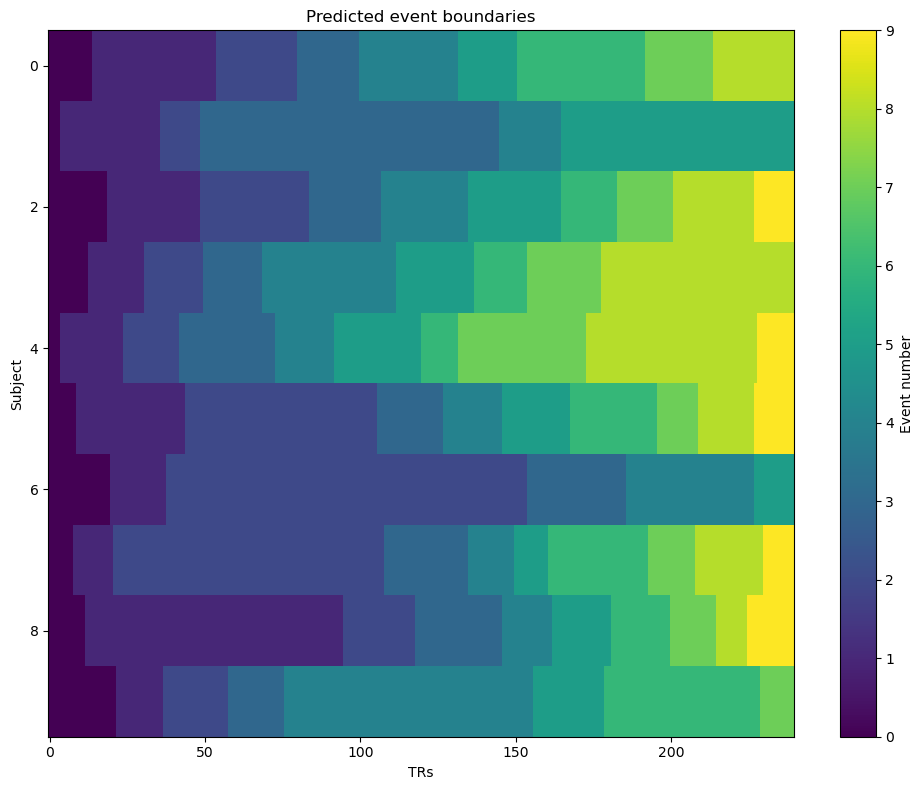

In [57]:
f, ax = plt.subplots(1,1, figsize = (10,8))
this_img=events_subj
im=ax.imshow(this_img, cmap='viridis', aspect='auto')
ax.set_ylabel('Subject')
ax.set_title('Predicted event boundaries')
ax.set_xlabel('TRs')
cbar=f.colorbar(im, orientation='vertical')
cbar.set_label('Event number', rotation=90)
f.tight_layout()
#f.savefig(fign)

In [58]:
# ks = np.arange(3, 15, 1)
print(loglik)
print(all_ll)
print(best_ll)
print(best_k_subj)
print(lls_inner)
print(lls_outer)
print(events_subj)

[[[-420.9901311  -421.1179793  -419.71850028 ...    0.
      0.            0.        ]
  [-421.77292964 -421.32763091 -420.52597774 ...    0.
      0.            0.        ]
  [-421.60523308 -421.13297014 -421.31803856 ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[-420.64647213 -420.97993802 -419.54107702 ...    0.
      0.            0.        ]
  [-421.76861629 -421.31841651 -421.02951448 ...    0.
      0.            0.        ]
  [-421.58761286 -421.23285197 -421.48836056 ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.       

In [ ]:
f, ax = plt.subplots(1,1, figsize = (10,8))
this_img=events_subj2
im=ax.imshow(this_img, cmap='viridis', aspect='auto')
ax.set_ylabel('Subject')
ax.set_title('Predicted event boundaries')
ax.set_xlabel('TRs')
cbar=f.colorbar(im, orientation='vertical')
cbar.set_label('Event number', rotation=90)
f.tight_layout()
#f.savefig(fign)

In [59]:
print(best_k_subj)

[ 9.  6. 10.  9. 10. 10.  6. 10. 10.  8.]


In [60]:
# n_subs = len(data) # total subjects
n_splits_inner = 4
nS = 9
subj_id_all = np.array([i for i in range(nS)])
loo_outer = LeaveOneOut()
subj_id_struct = idx
loo_outer.get_n_splits(subj_id_struct)

10

In [62]:
ks = np.arange(3, 20, 1)
loglik2=np.zeros((nS,nS,len(ks))) #preset a buncha variables
all_ll2=np.zeros((n_splits_inner,len(ks)))
best_ll2=np.zeros((nS,nS))
best_k_subj2=np.zeros((nS))
lls_inner2=np.zeros((nS))
lls_outer2=np.zeros((nS))
events_subj2=np.zeros((nS, 240))

for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)

    # set up inner loop loo structure
    subj_id_all_inner = subj_id_all[subj_id_train_outer]
    kf = KFold(n_splits=n_splits_inner)
    kf.get_n_splits(subj_id_train_outer)
    jj = 0

    print('Inner:')
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):

        # inplace update the ids w.r.t. to the inner training set
        subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
        subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]

        print("-Train:", subj_id_train_inner,"Validate:", subj_id_test_inner,
              ', now try different k...')
    
        D_train = data2[subj_id_train_inner,:,:] #14 subjects to be trained
        D_val = data2[subj_id_test_inner, :,:] #5 subjects for validation
        D_test = data2[subj_id_test_outer,:,:] #held-out subject
        ks = np.arange(3, 15, 1)
        splitm = True

        for knum in range(len(ks)): #loop through all possible K values
            #ev = brainiak.eventseg.event.EventSegment(ks[knum]) #set up HMM

            if splitm: #if running split_merge
                ev = EventSegment(ks[knum],split_merge=True)
            else: #if no split_merge
                ev = EventSegment(ks[knum])

            ev.fit(D_train.mean(0)) #fit to average pattern of training set
            segments,ll=ev.find_events(D_val.mean(0))#grab segments + log lik on average of validation set
            #print('log likelihood for k=%s is %s' %(ks[knum],ll)) #uncomment to see ll values
            
            loglik2[subj_id_test_outer,jj,knum] = ll #store loglik value for this K

        all_ll2[jj,:]=loglik2[subj_id_test_outer,jj,:]
        best_ll2[subj_id_test_outer,jj] = np.max(loglik2[subj_id_test_outer,jj,:]) #best loglik!
        jj=jj+1

    mean_all_ll2=np.mean(all_ll,axis=0) #grab mean log lik
    fill3=mean_all_ll2.argsort() #sort by log likelihood value
    fill3=fill3[len(ks)-1] #find best K

    print('Best K = %s' %fill3) #print best K
    best_k_subj2[subj_id_test_outer]=ks[fill3] #store best k to assign for this sub

    if splitm: #if running split_merge
        ev = EventSegment(ks[fill3],split_merge=True) #re-train model w/ this best K
    else: #if no split_merge
        ev = EventSegment(ks[fill3]) #re-train model w/ this best K

    #ev.fit(D[:,:,np.arange(nS) != subj_id_test_outer].mean(2).T) #fit
    ev.fit(D_test.mean(0)) #fit
    segments,ll=ev.find_events(D_test.mean(0)) #apply model to find segments and log lik
    lls_outer2[subj_id_test_outer]=np.max(ev.ll_) #store log lik
    events_subj2[subj_id_test_outer,:]=np.argmax(ev.segments_[0], axis=1) #find event boundaries
    
print(lls_outer2)
print(events_subj2)

Outer:	Train: [1 2 3 4 5 6 7 8] Test: [0]
Inner:
-Train: [3 4 5 6 7 8] Validate: [1 2] , now try different k...
-Train: [1 2 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [1 2 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [1 2 3 4 5 6] Validate: [7 8] , now try different k...
Best K = 5
Outer:	Train: [0 2 3 4 5 6 7 8] Test: [1]
Inner:
-Train: [3 4 5 6 7 8] Validate: [0 2] , now try different k...
-Train: [0 2 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [0 2 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [0 2 3 4 5 6] Validate: [7 8] , now try different k...
Best K = 5
Outer:	Train: [0 1 3 4 5 6 7 8] Test: [2]
Inner:
-Train: [3 4 5 6 7 8] Validate: [0 1] , now try different k...
-Train: [0 1 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [0 1 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [0 1 3 4 5 6] Validate: [7 8] , now try different k...
Best K = 5
Outer:	Train: [0 1 2 4 5 6 7 8] Test: [3]
Inner:
-Train: [2 4 5 

In [90]:
print(best_k_subj) # struc
print()
print(best_k_subj2) # randome

[ 9.  6. 10.  9. 10. 10.  6. 10. 10.  8.]

[8. 8. 8. 8. 8. 8. 8. 8. 8.]


## Structured

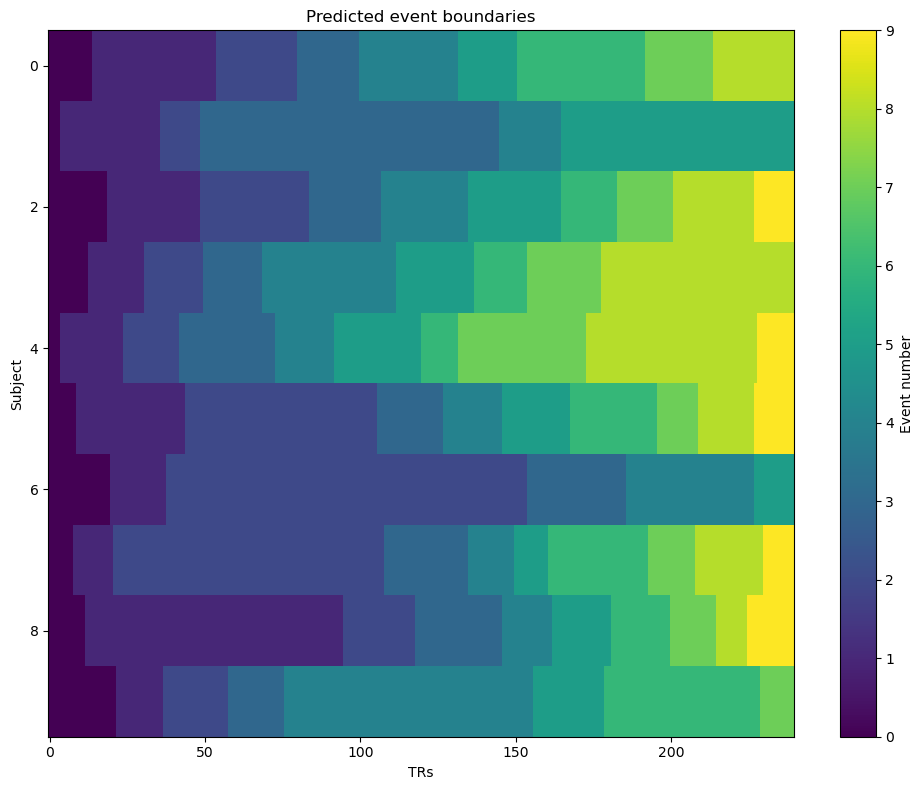

In [88]:
f, ax = plt.subplots(1,1, figsize = (10,8))
this_img=events_subj
im=ax.imshow(this_img, cmap='viridis', aspect='auto')
ax.set_ylabel('Subject')
ax.set_title('Predicted event boundaries')
ax.set_xlabel('TRs')
cbar=f.colorbar(im, orientation='vertical')
cbar.set_label('Event number', rotation=90)
f.tight_layout()

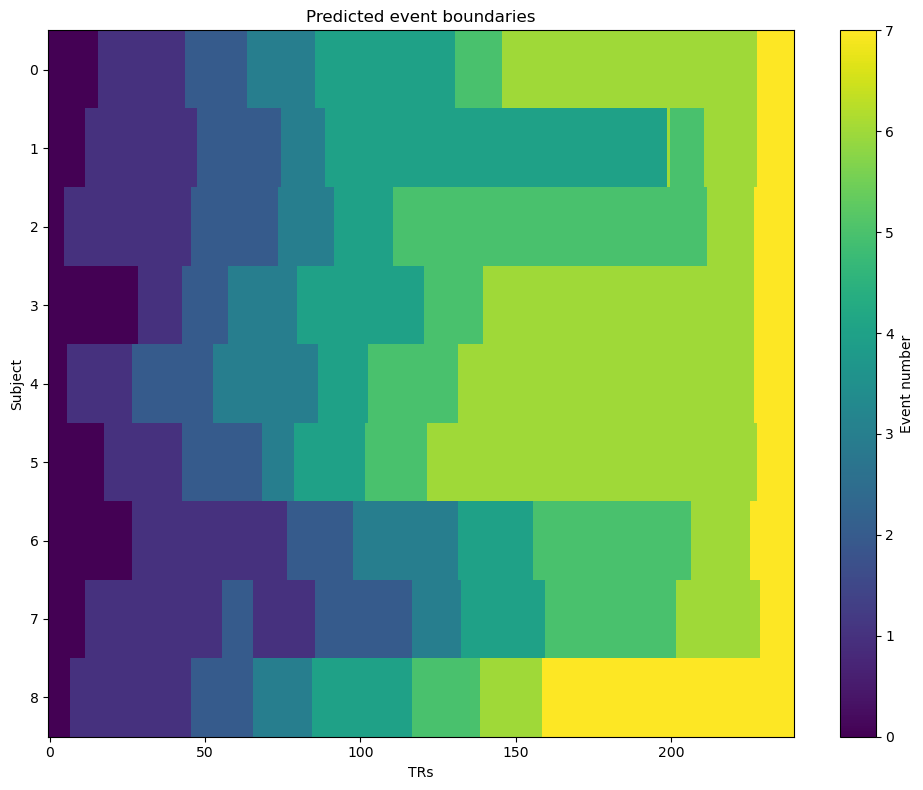

In [89]:
f, ax = plt.subplots(1,1, figsize = (10,8))
this_img2=events_subj2
im=ax.imshow(this_img2, cmap='viridis', aspect='auto')
ax.set_ylabel('Subject')
ax.set_title('Predicted event boundaries')
ax.set_xlabel('TRs')
cbar=f.colorbar(im, orientation='vertical')
cbar.set_label('Event number', rotation=90)
f.tight_layout()
#f.savefig(fign)

In [82]:
X = events_subj2
np.mean(X, axis=0).shape

(240,)

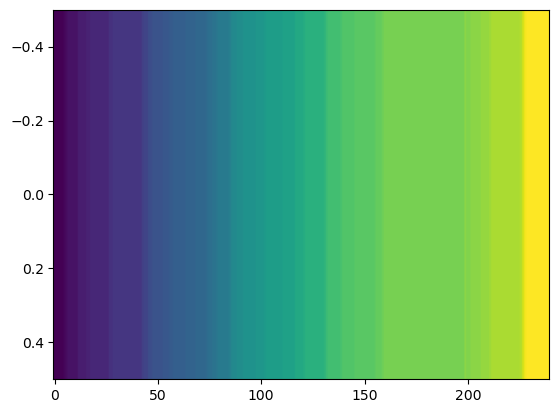

In [87]:
plt.imshow(X.mean(0).reshape(1, -1), aspect='auto')

In [7]:
data1 = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/struc_masked_conf_data.npy")
data2 = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/rand_masked_conf_data.npy")
data.shape

(10, 240, 48)

In [15]:
k_array = np.arange(3, 20, 1)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Trying %d events' % k)
    
    print('   Fitting model on training subjects...')
    data_train = np.mean(data1[8:], axis = 0)
    print()
    print(data_train.shape)
    data_HMM = EventSegment(k)
    data_HMM.fit(data_train)
    
    print('   Testing model fit on held-out subjects...')
    data_test = np.mean(data[9:], axis = 0)
    _, test_ll[i] = data_HMM.find_events(data_test)

Trying 3 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 4 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 5 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 6 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 7 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 8 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 9 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 10 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 11 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on he

In [47]:
x = k_array[np.argmax(test_ll)]
x

19

Text(0.5, 0, 'Average event length (sec)')

/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


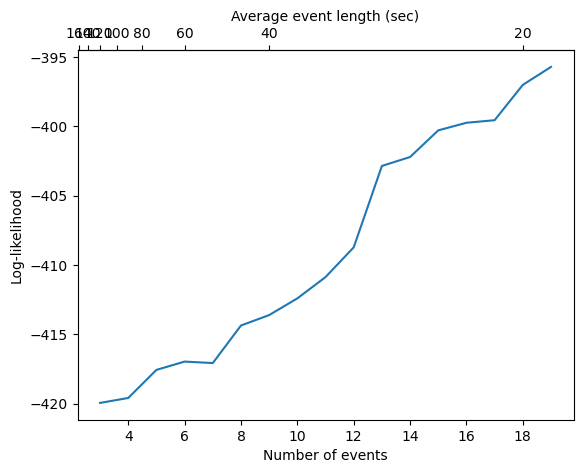

In [16]:
plt.plot(k_array, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

movie_dur = 240 * 1  # Data acquired every 1.5 seconds
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
secax.set_xlabel('Average event length (sec)')

In [8]:
data2.shape

(9, 240, 48)

In [48]:
k_array2 = np.arange(3, 20, 1)
test_ll2 = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Trying %d events' % k)
    
    print('   Fitting model on training subjects...')
    data_train = np.mean(data2[7:], axis = 0)
    print()
    print(data_train.shape)
    data_HMM = EventSegment(k)
    data_HMM.fit(data_train)
    
    print('   Testing model fit on held-out subjects...')
    data_test = np.mean(data[8:], axis = 0)
    _, test_ll[i] = data_HMM.find_events(data_test)

Trying 3 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 4 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 5 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 6 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 7 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 8 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 9 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 10 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on held-out subjects...
Trying 11 events
   Fitting model on training subjects...

(240, 48)
   Testing model fit on he

In [49]:
k_array2[np.argmax(test_ll2)]

3

Text(0.5, 0, 'Average event length (sec)')

/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


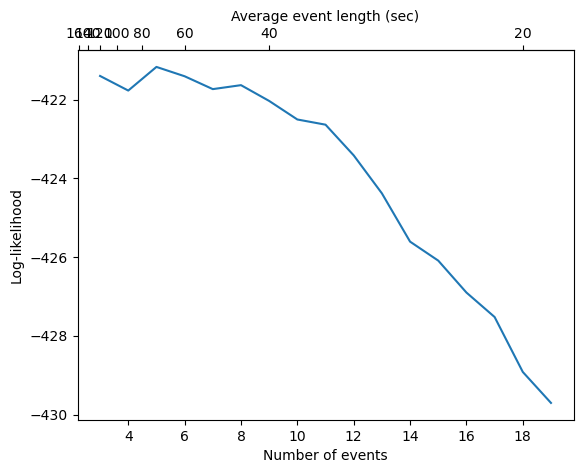

In [14]:
plt.plot(k_array, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

movie_dur = 240 * 1.5  # Data acquired every 1.5 seconds
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
secax.set_xlabel('Average event length (sec)')

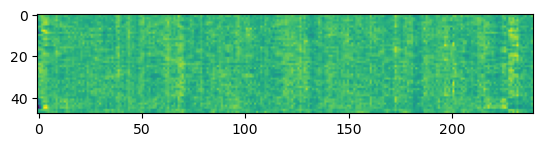

In [19]:
struct_ga = data1.mean(0)
plt.imshow(struct_ga.T)

In [42]:
E = EventSegment(14)
E.fit(struct_ga)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=14)

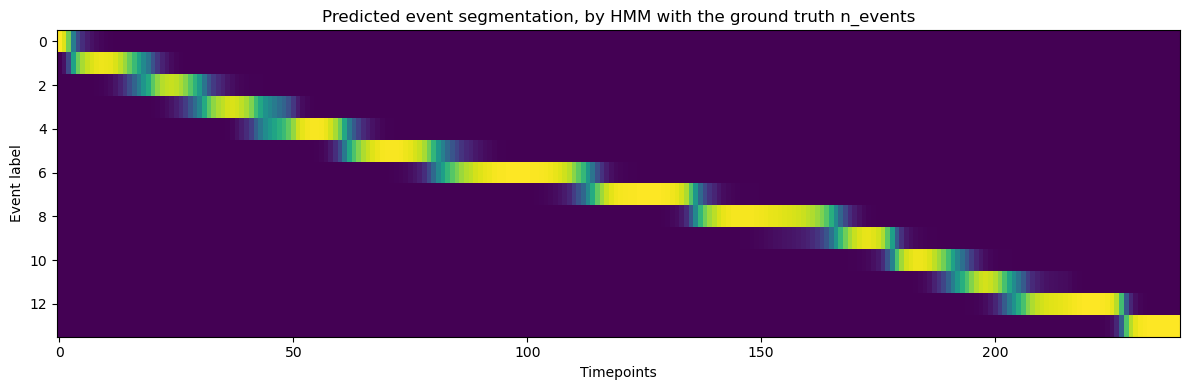

In [43]:
# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

pred_seg = E.segments_[0]
ax.imshow(pred_seg.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Event label')
ax.set_title('Predicted event segmentation, by HMM with the ground truth n_events')

f.tight_layout()

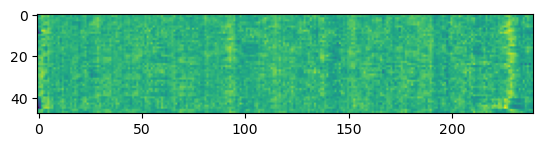

In [23]:
rand_ga = data2.mean(0)
plt.imshow(rand_ga.T)

In [44]:
V = EventSegment(13)
V.fit(rand_ga)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=13)

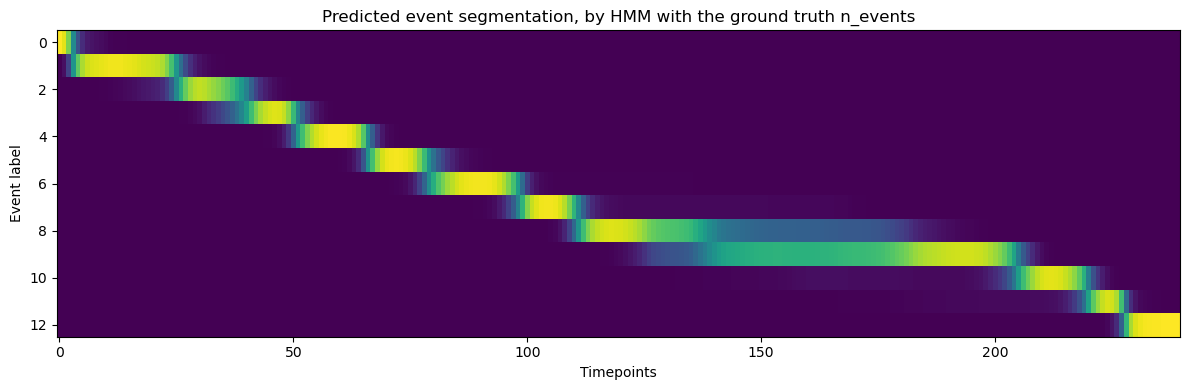

In [45]:
# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

pred_seg = V.segments_[0]
ax.imshow(pred_seg.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Event label')
ax.set_title('Predicted event segmentation, by HMM with the ground truth n_events')

f.tight_layout()

In [74]:
# fit event seg models 
k = 14
hm2 = EventSegment(k)
hm2.fit(aslist)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=14)

In [75]:
s, l = hm2.find_events(aslist[0])

In [76]:
l

-416.0492191451398

In [83]:
np.max(hm2.ll_.mean(1))

-411.42010420074973

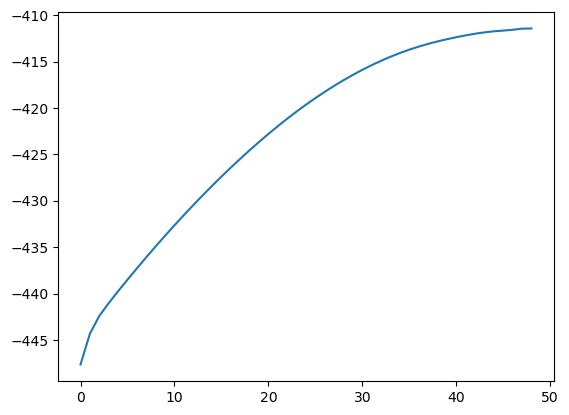

In [38]:
plt.plot(hm2.ll_.mean(1))
# print(np.max(hmm_ag_mvr.ll_.mean(1)))

In [42]:
seg, ll = hm2.find_events(strucdat[5])

In [45]:
ll

-413.76851609345687

In [21]:
idx = np.array([1, 2, 3, 4, 5])
subs2tst = strucdat[idx, :, :]
type(subs2tst)

numpy.ndarray

In [29]:
aslist = []
for i, j in enumerate(subs2tst):
    aslist.append(subs2tst[i, :, :])

In [30]:
len(aslist)

5

In [31]:
aslist[0].shape

(240, 48)

Text(0, 0.5, 'Events')

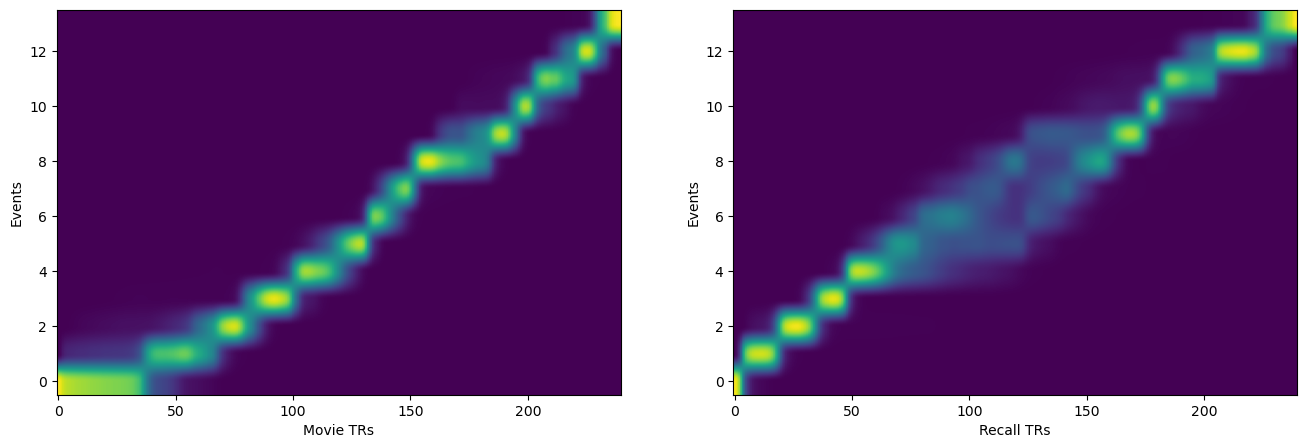

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.imshow(hmm_ag_mvr.segments_[0].T,aspect='auto',origin='lower',cmap='viridis')
plt.xlabel('Movie TRs')
plt.ylabel('Events')

plt.subplot(1,2,2)
plt.imshow(hmm_ag_mvr.segments_[1].T,aspect='auto',origin='lower',cmap='viridis')
plt.xlabel('Recall TRs')
plt.ylabel('Events')

# NOtes from 04/04

- Make model fit to list of subject's data
- Make inner loop test on one subject

In [89]:
def eventseg(data, idx:np.ndarray, k_vals:np.ndarray, n_splits:int, n_TR:int, split:bool=True, verbose:bool=False, concat:bool=False):

    # print
    if verbose:
        print()
        print('Running: Leave-one-out nested cross validation')
        print('----------------------------------------------\n')

    # some variables needed
    outer = LeaveOneOut()
    best_k = np.zeros_like(idx)
    best_ll = np.zeros((len(idx), len(idx)))
    ll_outer = np.zeros_like(idx)
    events = np.zeros((len(idx), n_TR))
    loglik = np.zeros((len(idx),len(idx),len(k_vals)))
    all_ll = np.zeros((n_splits,len(k_vals)))

    # start outer loop
    for outer_train_idx, outer_test_idx, in outer.split(idx):

        # print
        if verbose:
            print("Outer:\tTrain:", outer_train_idx, "Test:", outer_test_idx)

        # set up inner loop variables
        inner_idx = idx[outer_train_idx]
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(outer_train_idx)
        jj = 0 # update variable

        # print
        if verbose:
            print('\nInner:')

        # start inner loop
        for inner_train_idx, inner_test_idx in kf.split(inner_idx):

            # parse data by splits (is this redundant?)
            inner_train_idx = inner_idx[inner_train_idx]
            inner_test_idx = inner_idx[inner_test_idx]

            # subset data
            data_train = data[inner_train_idx]
            data_val = data[inner_test_idx]
            data_test = np.squeeze(data[outer_test_idx], axis=0)
        
            # print
            if verbose:
                print("-Train:", inner_train_idx,"Validate:", inner_test_idx)

            # begin loop to tune K
            for i, k in enumerate(k_vals):

                # instantiate EventSegment class
                if split:
                    HMM = EventSegment(n_events=k, split_merge=True)
                else:
                    HMM = EventSegment(n_events=k)

                # fit
                if concat:
                    HMM.fit(data_train.mean(0))
                else:
                    data_train_list = []
                    for i in range(len(data_train)):
                        data_train_list.append(data_train[i, :, :])
                        
                    HMM.fit(data_train_list)

                # test
                _, ll, = HMM.find_events(data_val.mean(0))

                # store ll
                loglik[outer_test_idx,jj,i] = ll

            # update other trackers
            all_ll[jj,:]=loglik[outer_test_idx,jj,:] # all log-likelihoods
            best_ll[outer_test_idx, jj] = np.max(loglik[outer_test_idx,jj,:]) # best log-likelihood
            jj += 1

        # update more trackers
        mean_ll = np.mean(all_ll, axis=0) # mean of log-likelihood
        fill = mean_ll.argsort() # sort by log-likelihood value
        fill = fill[len(k_vals)-1] # find best K
        best_k[outer_test_idx] = k_vals[fill] # store best K for test

        # instantiate EventSegment class
        if split:
            HMM = EventSegment(n_events=k, split_merge=True)
        else:
            HMM = EventSegment(n_events=k)

        # test and find events
        HMM.fit(data_test)
        _, ll = HMM.find_events(data_test)
        ll_outer[outer_test_idx] = np.max(HMM.ll_)
        events[outer_test_idx, :] = np.argmax(HMM.segments_[0], axis=1)

    if verbose:
        print("\nDone!")

    return {"Best_k": best_k, "events": events, "Best_LL":best_ll, "LL":loglik}

In [90]:
idx = np.arange(len(strucdat))
OUT = eventseg(data=strucdat, idx=idx, k_vals=k_vals, n_splits=4, n_TR=240, split=True, verbose=True, concat=True)


Running: Leave-one-out nested cross validation
----------------------------------------------

Outer:	Train: [1 2 3 4 5 6 7 8 9] Test: [0]
Inner:
-Train: [4 5 6 7 8 9] Validate: [1 2 3] , now try different k...
-Train: [1 2 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [1 2 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [1 2 3 4 5 6 7] Validate: [8 9] , now try different k...
Outer:	Train: [0 2 3 4 5 6 7 8 9] Test: [1]
Inner:
-Train: [4 5 6 7 8 9] Validate: [0 2 3] , now try different k...
-Train: [0 2 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [0 2 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [0 2 3 4 5 6 7] Validate: [8 9] , now try different k...
Outer:	Train: [0 1 3 4 5 6 7 8 9] Test: [2]
Inner:
-Train: [4 5 6 7 8 9] Validate: [0 1 3] , now try different k...
-Train: [0 1 3 6 7 8 9] Validate: [4 5] , now try different k...
-Train: [0 1 3 4 5 8 9] Validate: [6 7] , now try different k...
-Train: [0 1 3 4 5 6 7] Validate: [8

In [102]:
k_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [91]:
OUT

{'Best_k': array([ 9,  6, 10,  9, 10, 10,  6, 10, 10,  8]),
 'events': array([[ 0.,  0.,  0., ..., 13., 13., 13.],
        [ 0.,  0.,  0., ..., 13., 13., 13.],
        [ 0.,  0.,  0., ..., 13., 13., 13.],
        ...,
        [ 0.,  0.,  0., ..., 13., 13., 13.],
        [ 0.,  0.,  0., ..., 13., 13., 13.],
        [ 0.,  0.,  0., ..., 13., 13., 13.]]),
 'Best_LL': array([[-419.01785533, -419.89908048, -420.79155967, -419.84979594,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [-418.98432544, -420.73410902, -421.23285197, -419.93947085,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [-420.81080022, -420.8676811 , -421.26974003, -420.43793417,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ],
        [-421.01169209, -420.55071478, -420.68158348, -418.32202603,
            0.        ,    0.  

TypeError: Invalid shape (240,) for image data

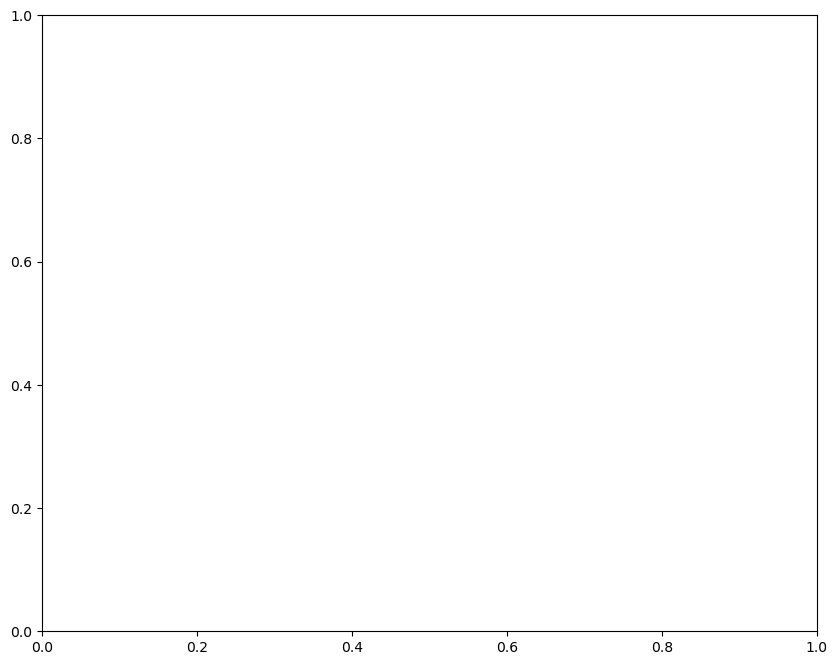

In [94]:
f, ax = plt.subplots(1,1, figsize = (10,8))
im=ax.imshow(OUT["events"], cmap='viridis', aspect='auto')
ax.set_ylabel('Subject')
ax.set_title('Predicted event boundaries')
ax.set_xlabel('TRs')
cbar=f.colorbar(im, orientation='vertical')
cbar.set_label('Event number', rotation=90)
f.tight_layout()
#f.savefig(fign)

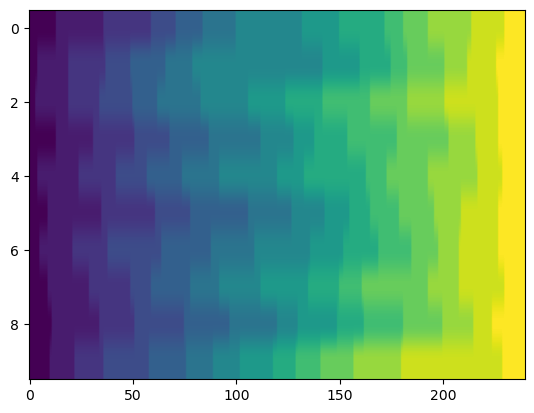

In [101]:
plt.imshow(OUT["events"][:, :], aspect='auto')

In [107]:
OUT["Best_k"]

array([ 9,  6, 10,  9, 10, 10,  6, 10, 10,  8])

In [108]:
RANDOUT = eventseg(data=randat, idx=np.arange(len(randat)), k_vals=np.arange(3, 15, 1), n_splits=4, n_TR=240, verbose=True, concat=True)


Running: Leave-one-out nested cross validation
----------------------------------------------

Outer:	Train: [1 2 3 4 5 6 7 8] Test: [0]
Inner:
-Train: [3 4 5 6 7 8] Validate: [1 2] , now try different k...
-Train: [1 2 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [1 2 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [1 2 3 4 5 6] Validate: [7 8] , now try different k...
Outer:	Train: [0 2 3 4 5 6 7 8] Test: [1]
Inner:
-Train: [3 4 5 6 7 8] Validate: [0 2] , now try different k...
-Train: [0 2 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [0 2 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [0 2 3 4 5 6] Validate: [7 8] , now try different k...
Outer:	Train: [0 1 3 4 5 6 7 8] Test: [2]
Inner:
-Train: [3 4 5 6 7 8] Validate: [0 1] , now try different k...
-Train: [0 1 5 6 7 8] Validate: [3 4] , now try different k...
-Train: [0 1 3 4 7 8] Validate: [5 6] , now try different k...
-Train: [0 1 3 4 5 6] Validate: [7 8] , now try different k...
O

In [109]:
RANDOUT["Best_k"]

array([8, 8, 7, 8, 6, 9, 8, 9, 9])

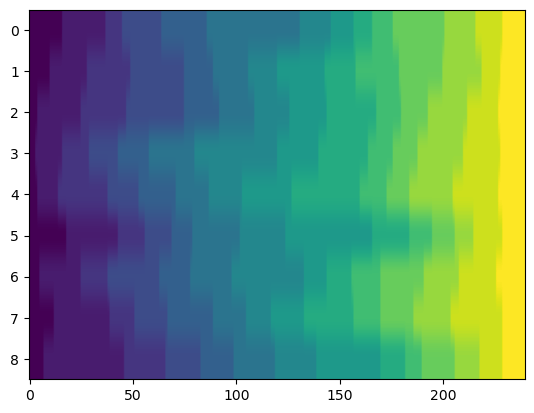

In [110]:
plt.imshow(RANDOUT["events"], aspect='auto')

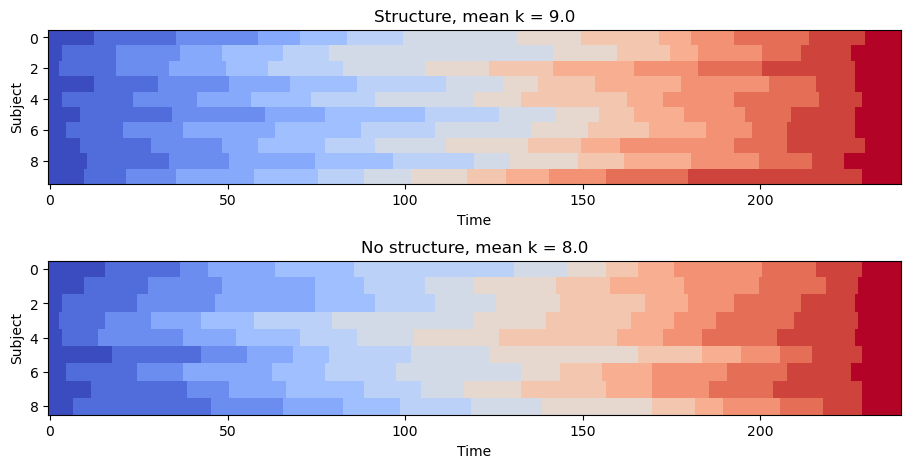

In [4]:
fig, ax = plt.subplots(nrows=2, figsize=(11, 5))

# fig.set_facecolor((236/255, 232/255, 232/255))

ax[0].imshow(OUT["events"], aspect='auto', cmap='coolwarm')
ax[0].set_title(f'Structure, mean k = {round(np.mean(OUT["Best_k"]), 0)}')
ax[0].set_ylabel('Subject')
ax[0].set_xlabel('Time')

ax[1].imshow(RANDOUT["events"], aspect='auto', cmap='coolwarm')
ax[1].set_title(f'No structure, mean k = {round(np.mean(RANDOUT["Best_k"]), 0)}')
ax[1].set_ylabel('Subject')
ax[1].set_xlabel('Time')
ax[1].set_facecolor("violet")

plt.subplots_adjust(hspace=0.5)

plt.savefig('/data/jdecke5/projects/honors-thesis/data/eventseg/allevents_4paper.png', dpi=800, bbox_inches='tight')

In [113]:
cmap = plt.cm.gray
norm = plt.Normalize(OUT["events"], RANDOUT["events"])
all = np.hstack(OUT["events"], RANDOUT["events"])
rgba = cmap(norm(all))

# change the color for keypresses from white to a color if this was a timepoint determined to be a boundary
for e, ev in enumerate(np.arange(240)):
    rgba[ev, all[ev]==1, :3] =  plt.cm.Paired.colors[e]

# actually plot it! 
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(rgba.transpose(1,0,2), interpolation='nearest')

ValueError: can only convert an array of size 1 to a Python scalar

In [115]:
print(round(np.mean(OUT["Best_k"]), 0))
print()
print(np.mean(RANDOUT["Best_k"]))

9.0

8.0


In [116]:
strucdat.shape

(10, 240, 48)

In [6]:
from scipy.stats import pearsonr

In [ ]:
np.save("/data/jdecke5/projects/honors-thesis/data/eventseg/structured_0407.npy", OUT, allow_pickle=True)
np.save("/data/jdecke5/projects/honors-thesis/data/eventseg/rand_0407.npy", RANDOUT, allow_pickle=True)

In [8]:
OUT = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/structured_0407.npy", allow_pickle=True)[()]
RANDOUT = np.load("/data/jdecke5/projects/honors-thesis/data/eventseg/rand_0407.npy", allow_pickle=True)[()]

# Testing boundaries for structured

In [20]:
round(OUT['Best_k'].mean(), 0)

9.0

In [10]:
k = int(round(OUT['Best_k'].mean(), 0))
w = 5  # window size
nPerm = 1000
nSubj = 10
nTR = 240


within_across = np.zeros((nSubj, nPerm+1))
for left_out in range(nSubj):
    # Fit to all but one subject
    ev = EventSegment(k)
    ev.fit(strucdat[np.arange(nSubj) != left_out, :, :].mean(0))
    events = np.argmax(ev.segments_[0], axis=1)

    # Compute correlations separated by w in time
    corrs = np.zeros(nTR-w)
    for t in range(nTR-w):
        corrs[t] = pearsonr(strucdat[left_out, t, :],strucdat[left_out,t+w,:])[0]
    _, event_lengths = np.unique(events, return_counts=True)

    # Compute within vs across boundary correlations, for real and permuted bounds
    np.random.seed(0)
    for p in range(nPerm+1):
        within = corrs[events[:-w] == events[w:]].mean()
        across = corrs[events[:-w] != events[w:]].mean()
        within_across[left_out, p] = within - across
        # 
        perm_lengths = np.random.permutation(event_lengths)
        events = np.zeros(nTR, dtype=np.int)
        events[np.cumsum(perm_lengths[:-1])] = 1
        events = np.cumsum(events)
    print('Subj ' + str(left_out+1) + ': within vs across = ' + str(within_across[left_out,0]))

/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 1: within vs across = 0.016537209330038716


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 2: within vs across = -0.05844798122314064


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 3: within vs across = 0.06014917537962958


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 4: within vs across = -0.020486149304303404


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 5: within vs across = 0.029780136368682236


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 6: within vs across = 0.06911010305784179


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 7: within vs across = -0.023309117866153382


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 8: within vs across = 0.07071180684696454


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 9: within vs across = -0.08422448938750066
Subj 10: within vs across = -0.08124604383301966


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


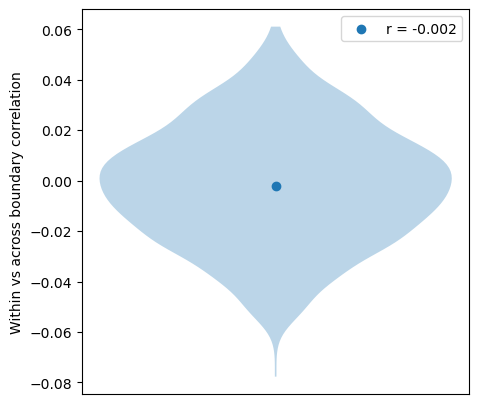

In [11]:
plt.figure(figsize=(5,5))


plt.violinplot(within_across[:,1:].mean(0), showextrema=False)
plt.scatter(1, within_across[:,0].mean(0), label=f'r = {round(within_across[:,0].mean(0), 3)}')
plt.legend()
plt.gca().xaxis.set_visible(False)

# plt.gcf().set_facecolor((236/255, 232/255, 232/255))
# plt.gca().set_facecolor((236/255, 232/255, 232/255))

plt.ylabel('Within vs across boundary correlation')
plt.savefig('/data/jdecke5/projects/honors-thesis/data/eventseg/struc_comparison_4paper.png', dpi=800, bbox_inches='tight')

In [53]:
within_across[:,0].mean(0)

-0.002142535063096089

In [41]:
mevent = OUT["events"]

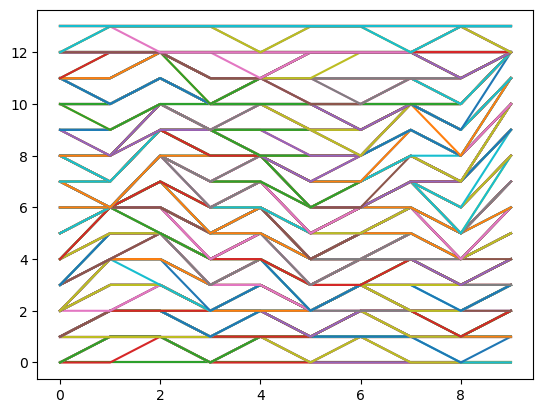

In [42]:
plt.plot(mevent)

# Testing random boundaries

In [12]:
k = int(round(RANDOUT['Best_k'].mean(), 0))
w = 5  # window size
nPerm = 1000
nSubj = 9
nTR = 240


within_across = np.zeros((nSubj, nPerm+1))
for left_out in range(nSubj):
    # Fit to all but one subject
    ev = EventSegment(k)
    ev.fit(randat[np.arange(nSubj) != left_out, :, :].mean(0))
    events = np.argmax(ev.segments_[0], axis=1)

    # Compute correlations separated by w in time
    corrs = np.zeros(nTR-w)
    for t in range(nTR-w):
        corrs[t] = pearsonr(randat[left_out, t, :],randat[left_out,t+w,:])[0]
    _, event_lengths = np.unique(events, return_counts=True)

    # Compute within vs across boundary correlations, for real and permuted bounds
    np.random.seed(0)
    for p in range(nPerm+1):
        within = corrs[events[:-w] == events[w:]].mean()
        across = corrs[events[:-w] != events[w:]].mean()
        within_across[left_out, p] = within - across
        # 
        perm_lengths = np.random.permutation(event_lengths)
        events = np.zeros(nTR, dtype=np.int)
        events[np.cumsum(perm_lengths[:-1])] = 1
        events = np.cumsum(events)
    print('Subj ' + str(left_out+1) + ': within vs across = ' + str(within_across[left_out,0]))

/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 1: within vs across = 0.1093703674168214


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 2: within vs across = -0.0525341279687314


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 3: within vs across = -0.05583250373427677


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 4: within vs across = 0.04394718986895132


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 5: within vs across = -0.0717538858205304


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 6: within vs across = -0.019374128924993843


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 7: within vs across = 0.18150345511231944


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Subj 8: within vs across = 0.04341687357390949
Subj 9: within vs across = 0.03439970311053727


/data/.conda/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


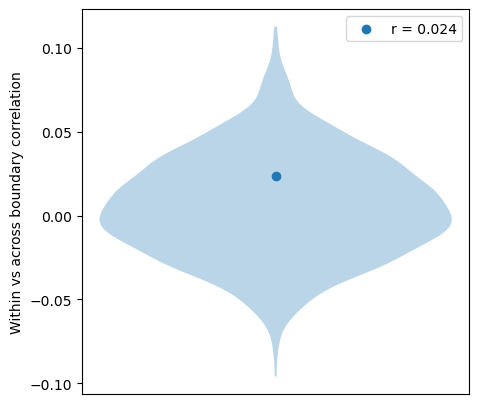

In [13]:
plt.figure(figsize=(5,5))

plt.violinplot(within_across[:,1:].mean(0), showextrema=False)
plt.scatter(1, within_across[:,0].mean(0), label=f'r = {round(within_across[:,0].mean(0), 3)}')
plt.legend()
plt.gca().xaxis.set_visible(False)

# plt.gcf().set_facecolor((236/255, 232/255, 232/255))
# plt.gca().set_facecolor((236/255, 232/255, 232/255))

plt.ylabel('Within vs across boundary correlation')
plt.savefig('/data/jdecke5/projects/honors-thesis/data/eventseg/rand_comparison_4paper.png', dpi=800, bbox_inches='tight')

In [49]:
within_across[:,0].mean(0)

0.02368254918155628

In [134]:
sbounds = OUT["events"].mean(0)
sbounds.ndim(

TypeError: 'int' object is not callable

In [137]:
sbounds = np.where((np.argmax(sbounds[0], axis=0)))

In [ ]:
np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in human_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(human_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))